In [4]:
# Basic libraries
import pandas as pd
import numpy as np
import regex as re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing – encoding
from sklearn import preprocessing

# Data Cleaning

In [5]:
# Open csv file, and create DataFrame
with open('Kaggle_Salary.csv') as csv_file:
    df = pd.read_csv(csv_file)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's look at a small sample of the data.

In [9]:
df.head()

,Unnamed: 0,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,index
0,0,Duration (in seconds),What is your gender? - Selected Choice,What is your gender? - Prefer to self-describe...,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,Select the title most similar to your current ...,...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,What barriers prevent you from making your wor...,NaN
1,2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0.0
2,3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0
3,5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,2.0
4,7,959,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,...,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1,3.0


To begin with, let's have a look at how many null values are in each of the 395 columns.

In [10]:
df.isnull().sum()

Unnamed: 0                                 0
Time from Start to Finish (seconds)        0
Q1                                         0
Q1_OTHER_TEXT                              0
Q2                                         0
Q3                                         0
Q4                                         0
Q5                                       135
Q6                                         0
Q6_OTHER_TEXT                              0
Q7                                         0
Q7_OTHER_TEXT                              0
Q8                                        76
Q9                                         0
Q10                                      292
Q11_Part_1                              7966
Q11_Part_2                             11186
Q11_Part_3                             11278
Q11_Part_4                              9705
Q11_Part_5                             11845
Q11_Part_6                             12914
Q11_Part_7                             14758
Q11_OTHER_

The first thing I have done is drop columns that I have deemed not useful, or have not been filled in properly during the survey; I have done this by manually looking through the various columns in the data set. This includes the 'Time from start to finish' column, the index column, and several others. For example, looking at column 'Q8', I can see that a large portion of candidates have provided dates instead of years (which is not useful).

In [11]:
df = df.drop(df.index[[0]]) # Drop first row (contains survey questions)
df = df.drop(['Q8', 'Q43', 'Q46', 'Unnamed: 0', 'Time from Start to Finish (seconds)', 'index'], axis = 1)

Additionally, all columns names containing the strings 'OTHER' or 'TEXT' are useless. These columns contain meaningless numbers that correspond to free-form text inputs, and there is no way of tracing the free-form text to the respondents. These columns have therefore been removed by filtering out columns containing these strings, and dropping them.

In [12]:
df = df[df.columns.drop(df.filter(regex='OTHER').columns)] # Drop columns containing string 'OTHER'
df = df[df.columns.drop(df.filter(regex='TEXT').columns)] # Drop columns containing string 'TEXT'

It is important to try and understand why certain columns are missing values. One observation is that columns with 'Part_1', 'Part_2', 'Part_3' etc. only have 2 unique values – one of which ia a null value. As such, the majority of data in these columns appears to be missing, however there is a reason these values are missing (e.g. for 'Q16_Part_3' the respondent does not use SQL on a regular basis, and so the value is null). As such, these columns are 'informative-missings', and will be kept; they will be treated as binary categorical columns.

However, those columns that no have various parts, should ideally not have a high proportion of NaNs. Any NaNs contained in these columns are 'non-informative-missings'. The for loop below is used to identify columns that have more than 20% NaN values, that do not have several parts (and therefore a known reason for having a large portion of NaNs).

In [13]:
# Return column names that do not have a single answer (majority NaNs), but have more than 20% missing data
for column in df.columns:
    if 'Part' not in column and df[column].isnull().mean()*100>20:
        print(str(df[column].isnull().mean()*100) + '% of column ' + str(column) + ' is' + ' missing.')

28.135329574178495% of column Q17 is missing.
37.39062803811005% of column Q20 is missing.
40.46276492319657% of column Q22 is missing.
33.21666990731739% of column Q32 is missing.
52.757793764988016% of column Q37 is missing.
24.389137338777626% of column Q40 is missing.
35.09624732646316% of column Q48 is missing.


Imputing missing values always produces some bias in the data. Filling in the columns identified above with the modal value would introduce significant bias into the data, and so they will be dropped instead.

In [7]:
# Drop columns that do not have a systematic reason for containing a large number of NaN values (not in parts).
df = df.drop(['Q17','Q20', 'Q22', 'Q32','Q37', 'Q40', 'Q48'], axis = 1)

I am also going to drop rows that do not have atleast 20 (non-NaN) values, since these rows do not contain much useful information to perform regression analyses.

In [8]:
# Drop rows that do not have atleast 20 NaN values
df = df.dropna(axis = 0, thresh = 20)

Let's look at how many NaN values are contained in the remaining columns that do not have different parts (and therefore contain 'non-informative-missings'). The for loop below identifies these columns and prints the number of NaNs contained.

In [9]:
# Create empty list
fill_columns = []

for c in df.columns:   
    if 'Part' not in c:
        # Print column names, and number of NaNs
        print(c, df[c].isnull().sum())
        # Append to empty list (for use below)
        fill_columns.append(c)

Q1 0
Q2 0
Q3 0
Q4 0
Q5 92
Q6 0
Q7 0
Q9 0
Q10 0
Q12_MULTIPLE_CHOICE 0
Q18 33
Q23 138
Q24 157
Q25 183
Q26 192


It can be seen that the prior data cleaning steps have significantly decreased the number of unexplained NaNs contained in the dataset. For these columns, I am going to fill all the NaN values with the modal value for the column. While this still introduces some bias into the data, by over-emphasizing the number of modal values, the number of NaNs is relatively small, and so the bias introduced should not be too significant.

The line of code below uses panda's .mode function to retrieve the modal value for each column identified above (contained in the list 'fill_columns'), and then fills all NaNs with the retrieved modal values.

In [10]:
# Fill 'non-informative' missings with modal value for the column.
df[fill_columns] = df[fill_columns].fillna(df[fill_columns].mode)

Having cleaned the data, categorical columns can now be encoded so that it can be processed by machine learning algorithms. I have chosen to use sklearn's Label Encoder, which assigns each unique categorical variable in a column with a different integer value. This is not an ideal method, because encoding in this way introduces ordinality into the categorical variables (from the perspective of the algorithm), even though the data is nominal. For example, if 'Male' and 'Female' are encoded to 1 and 0 respectively, then the algorithm will ofcourse assume that 1>0, even though 'Male'>'Female' makes no sense. As such, this encoding method will decrease the accuracy of predictions. A better choice would be 'one-hot' encoding, which splits each unique value in a column into a binary 1 and 0 values, which works much better for nominal data. However, 'one-hot' encoding greatly increases the number of columns in the data, because a new column is needed for each unique value. After 'one-hot' encoding the data, I consistently ran into memory issues, even after applying PCA (I also tried IncrementalPCA) to reduce the number of dimensions of the data. Furthermore, although one-hot encoding increased the acurracy of the Lasso Regression algorithm by around 10%, the increase in accuracy for the other three (tree-based) algorithms was not significant. As such, I have decided to stick with label encoding, even though I am aware of the fault in this technique.

In [16]:
# Create new dataframe to be encoded
df_enc = df.copy()

Examining the data, it can be seen that all of it is categorical apart from the target variable (Q9). As such, this column should not be encoded, and therefore removed from the encoded DataFrame.

In [17]:
df_enc = df_enc.drop(['Q9'], axis = 1) # Remove (continuous) target variable from encoded dataframe

In [18]:
# Object for label encoding
le = preprocessing.LabelEncoder()

In [19]:
# Apply label encoding object to each column in the DataFrame
for col in df.columns.values.tolist():
    df_enc[col]=le.fit_transform(df[col].astype(str))

We can now see what the new (label encoded) DataFrame looks like.

In [20]:
df_enc.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q10,Q11_Part_1,Q11_Part_2,...,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q9
1,1,3,22,0,2,11,9,1,1,1,...,1,1,1,1,1,1,1,1,1,3560
2,0,3,56,3,1,7,7,0,0,1,...,1,1,0,1,1,1,1,1,1,5378
3,1,1,21,3,8,4,7,0,1,1,...,1,1,0,1,1,0,1,1,1,10969
4,1,4,8,1,7,11,0,1,1,1,...,1,0,1,1,1,1,0,1,1,1090
5,1,0,21,3,7,11,16,4,1,0,...,1,1,1,1,1,0,1,1,1,5317


The code below was used to perform 'one-hot' encoding. For the reasons discussed above, this encoding has not been used. Nonetheless, it is still interesting to see how 'one-hot' encoding alters the strucutre of the data.

In [22]:
# Function for one-hot encoding
def one_hot(df, cols):
    
    return [pd.get_dummies(df[col], prefix=col, drop_first=False) for col in cols]

enc = one_hot(df_enc, df_enc.columns)
# Concatenate each dataframe consisting of sub-solumns to a new DataFrame
df_one_hot = pd.concat(enc, axis=1)

In [23]:
df_one_hot.head()

,Q1_0,Q1_1,Q1_2,Q1_3,Q2_0,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,...,Q9_14001,Q9_14002,Q9_14003,Q9_14004,Q9_14005,Q9_14006,Q9_14007,Q9_14008,Q9_14009,Q9_14010
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It can be seen that now each column is split into various sub-columns consisting of binary values for each unique variable. For example, Q1 had 4 unique values – 'Male', 'Female, 'Prefer not to say' and 'Prefer to self-describe', and has therefore been split into 4 sub-columns as can be seen above. 'One-hot' encoding has increased the number of columns in the DataFrame to 14553!

In [18]:
df['Q9'].dtype

dtype('O')

Lastly, the data type of the target column must be changed from 'Object' to 'int64'.

In [19]:
# Convert target variable to numeric data type
df['Q9'] = pd.to_numeric(df['Q9'])

In [20]:
df['Q9'].dtype

dtype('int64')

# Exploratory Analysis

To begin my exploratory analysis, I am going to visualize the order of feature importances.

In [21]:
# Declare features (encoded DataFrame) and target variable (Q9)
X = df_enc
y = df['Q9']

To compute feature importance values, I am going to train a Random Forest Classifier model. This model evaluates feature importances based on information content (conditional entropy). Specifically, it implements Gini Importance, which means that each feature importance score is calculated by taking the sum over the number of splits that incude the feature (across all trees), in proportion to the number of samples it splits.

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Decision tree classifer for feature importance
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train DT classifier
model_importances = clf.fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
# Make feature importance scores into DataFrame, put values in descending order,  and map scores to feature names
feature_importances = pd.DataFrame(model_importances.feature_importances_, index = df_enc.columns,
                                    columns=['Feature_Importance']).sort_values('Feature_Importance',  ascending=False)

Let's plot feature importance for the top 100 features (350 features is too many to visualize in this notebook).

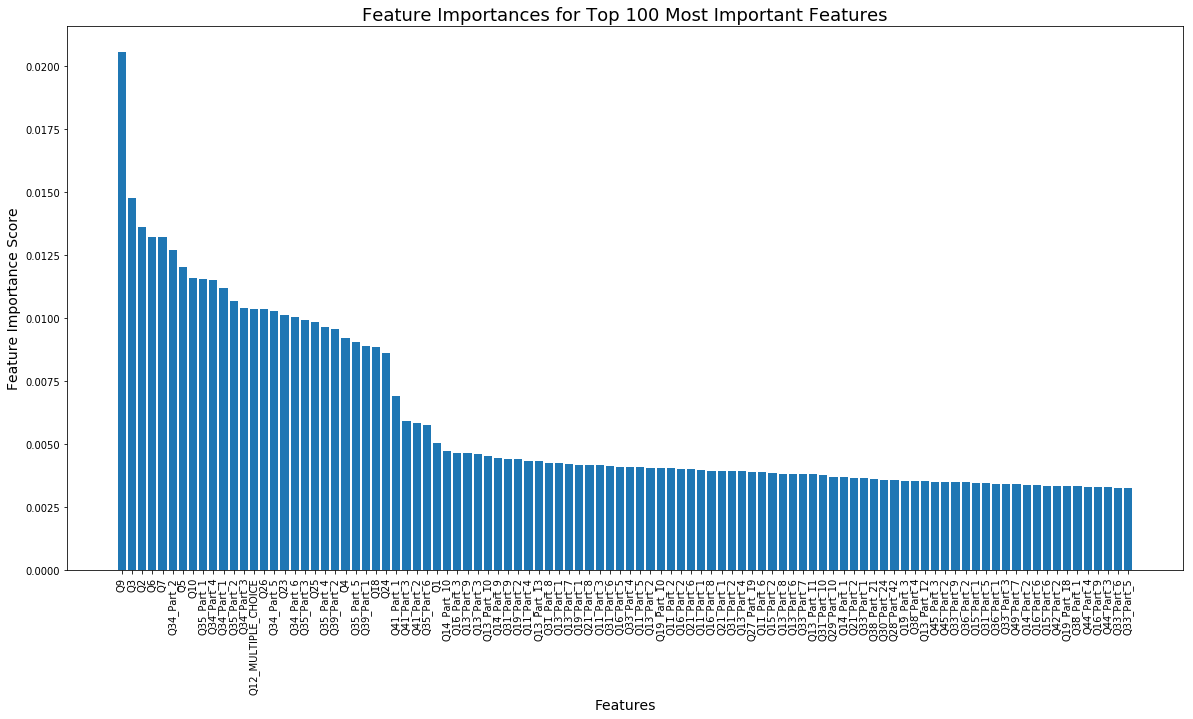

In [25]:
#Plot feature importance scores 
plt.figure( figsize=(20,10) )
plt.bar(feature_importances.head(n=100).index,feature_importances['Feature_Importance'].head(n=100))
plt.xticks(rotation='vertical')
plt.xlabel('Features', fontsize = 14)
plt.ylabel('Feature Importance Score', fontsize = 14)
plt.title('Feature Importances for Top 100 Most Important Features', fontsize = 18)
plt.show()

The plot of feature importances above shows that Q3, which is the country that the respondent resides in, is the most important feature in predicting yearly compensation. Intuitively, this makes sense since the cost of living (purchasing power) varies largely between nations. Other important features – in order – include Q2 (age), Q7 (industry), Q6 (job title), Q5 (undergraduate major), Q10 (whether their employer uses machine learning methods), and Q4 (highest level of formal education). After these features, there is a noticable drop in feature importance for the remaining features.

Next, I am going to visualize the number of respondents from each country.

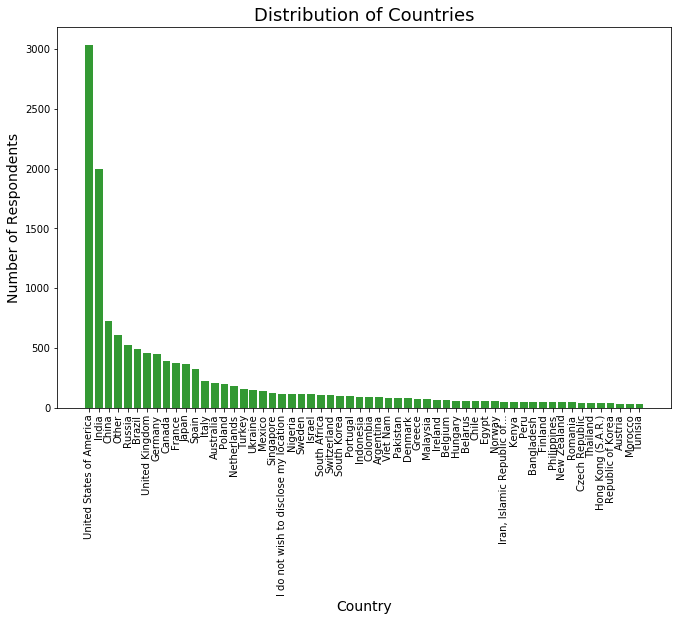

In [26]:
# Plot value_count of number of different countries in Q3 column
df['Q3'] = df['Q3'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom') # Replace long name
country_count  = df['Q3'].value_counts(sort = True)
plt.figure(figsize=(11,7))
plt.bar(country_count.index, country_count.values, alpha=0.8, color = 'green')
plt.title('Distribution of Countries', fontsize = 18)
plt.ylabel('Number of Respondents', fontsize=14)
plt.xlabel('Country', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

We can see that the USA has, by a significant margin, the most respondents. India comes in second, and then there is another aignificant drop in the number of respondents, with China taking third place. Canada occupies a fairly high position in this graph, considering its relatively low population size. It appears that this country has a disproportionate interest in Data Science!

Let's dig a little bit depper into the different salaries for each country.

In [27]:
for country in country_count.index.tolist():
    print('Average salary in ' + country + ': $' + str(df[df['Q3']==country]['Q9'].mean()))

Average salary in United States of America: $99687.26005273566
Average salary in India: $22520.444
Average salary in China: $22853.99172413793
Average salary in Other: $27532.781456953642
Average salary in Russia: $24022.43295019157
Average salary in Brazil: $27938.81930184805
Average salary in United Kingdom: $65657.6225165563
Average salary in Germany: $58992.66292134832
Average salary in Canada: $69704.63239074551
Average salary in France: $52728.41176470588
Average salary in Japan: $59090.86956521739
Average salary in Spain: $38803.118380062304
Average salary in Italy: $36629.8371040724
Average salary in Australia: $88538.0193236715
Average salary in Poland: $29863.072538860102
Average salary in Netherlands: $59867.19337016575
Average salary in Turkey: $16503.651898734177
Average salary in Ukraine: $24168.62328767123
Average salary in Mexico: $28995.364285714284
Average salary in Singapore: $59356.925619834714
Average salary in I do not wish to disclose my location: $41766.77777777

The code above further clarifies that average salaries vary widely dependent on the country of the respondents – salaries in the US and India are around \$98,000 and \$23,000 respectively, which is a really staggering difference. This is aligned with the results from feature importances, which showed that a respondent's country is the most important factor in predicting their salary. 

As such, it is more interesting to look at salaries through the lens of a specific country. Let's create a new DataFrame containing only datapoints for respondents from the USA, and visualize the distribution of salaries.

In [28]:
# Create new DataFrame filtering information only from US respondents
df_usa = df[df['Q3'] == 'United States of America']

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


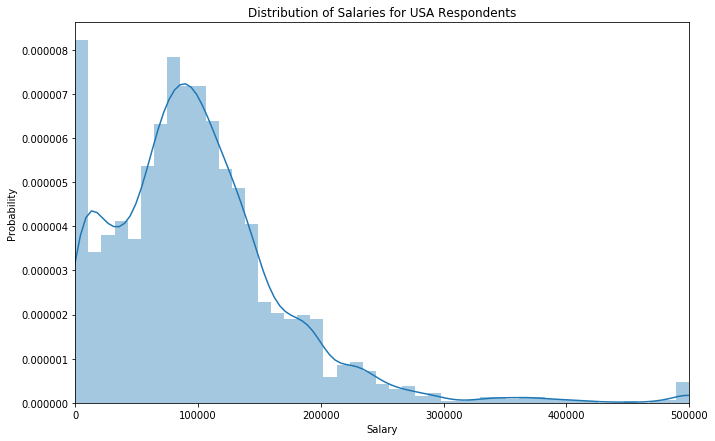

In [29]:
fig, ax = plt.subplots(figsize=(11,7))
plt.xlim(0,df_usa.Q9.max())
plt.title('Distribution of Salaries for USA Respondents')
plt.ylabel('Probability')
sns.distplot(ax = ax, a = df_usa['Q9'], axlabel='Salary')

The large number of salaries near zero reflects the many students that completed the survey. These respondents likely do not earn a yearly compensation yet. Apart from this, the salaries are distributed as you might expect; the majority of respondents have a salary near the mean value, and only a small number of people have a very high salary (>$250,000).

The gender pay-gap is a highly controversial topic; let's see what the Kaggle salary data has to say about this:

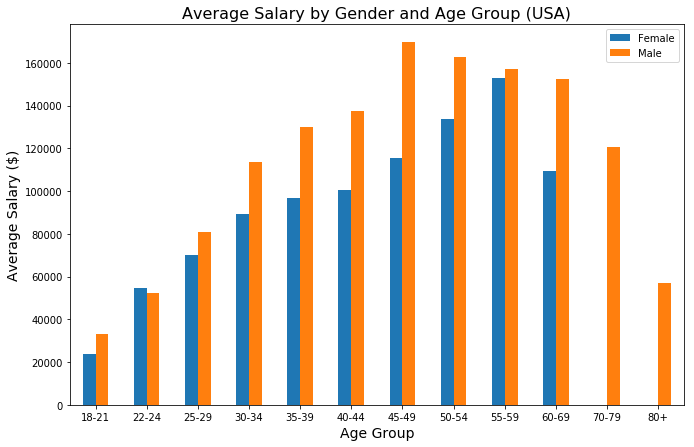

In [30]:
# Create DataFrame of average salaries by gender (only Male and Female)
gender_df = df_usa[df_usa['Q1'].isin(['Male', 'Female'])].pivot_table(values='Q9',index='Q2',columns='Q1')

# Create barplot
ax = gender_df.plot.bar(figsize = (11,7), rot = 0)
ax.set_title('Average Salary by Gender and Age Group (USA)', fontsize = 16)
ax.set_ylabel('Average Salary ($)', fontsize = 14)
ax.set_xlabel('Age Group', fontsize = 14)
ax.legend(['Female', 'Male'])

The plot above shows that there is indeed a significant gender pay gap for respondents in the Kaggle community; men earn more (on average) in every age group. This shows that gender is indeed useful in predicting the yearly compensation of the usrvey respondents. Noticeably, the gap generally increases with age group. The gap makes a significant leap at some point between ages 25 and 34, however the gap for 55-59 year olds almost closes. It is important to note that there were far more male respondents in total, and there were no female respondents from the USA aged over 70 (as can be seen from the chart). This means that the data does not provide a robust representation of gender pay differences, but it is still an interesting comparison!

# Feature Selection

Broadly speaking, feature engineering is the process of transforming raw data into features that can be used to as inputs for machine learning models. Features typically take the form of a column in a dataset. Needless to say, selecting high quality features is key to building a model that can generalise to unseen data. Selecting the right features is arguably the most important part of building a high-performing model. Feature engineering is where human-insight can be used to ensure that the model is provided with data that contains relevant indicators – in an appropriate format – to enable the model to learn the underlying patterns. Features can be inherent or derived. Derived features are 'engineered' through the application of some operation to raw data – this is also known as feature extraction.

Feature selection is the process of selecting a subset of relevant features to feed into a machine learning model. There are several benefits to feature selection including: (1) preventing overfitting and therfore enhancing the ability of the model generalise, (2) shorter training times, (3) making models easier to interpet, (4) avoiding the 'curse of dimensionality' (caused by a very large number of dimensions). Feature selection involves the removal of those features that are deemed irreelevant in the presence of other (more important) features.

To perform feature selection, I am going to use the model importances calculated by the Random Forest Classifier used previously.

In [31]:
from sklearn.feature_selection import SelectFromModel

In [32]:
# Pass prefit Random forest classifier (used to generate feature importances) into SelectFromModel Metatransformer
model_select = SelectFromModel(model_importances, prefit = True)

In [33]:
# Output column names of selected features.
features = df_enc.columns[model_select.get_support()]

In [34]:
len(features.tolist())

142

The threshold of feature importances was set to the default value, meaning that all features with an importance score above the mean score were selected. This threshold value was chosen through trial and error to see how the number of features selected affected the accuracy of the various regression models. Setting a different threshold value lead to a decrease in accuracy – this is my justification for selecting 142 features. The line above shows that this algorithm has selected 142 features; there are 142 features with an importance score above the mean score value.

In [35]:
# Change encoded dataframe to a subset of (142) columns for the selected features
df_enc = df_enc[features]

Below is the code that I used to apply PCA dimensionality reduction to the 'one-hot' encoded DataFrame. Since 'one-hot' encoding was not used, I have commented this code out.

In [36]:
# from sklearn.decomposition import PCA

#pca = PCA(n_components = 0.9) # n_components set to 0.9 so that No. of components explains 90% of variance

#pca.fit(X)
#X_pca = pca.transform(X)
#print('PCA has reduced the dimensionality of the features from ' +  str(X.shape) + ' to ' + str(X_pca.shape))

# NB: can use n_components as a hyperparameter for each model

# Model Implementation

Havings cleaned tha data, and selected the features to use, it is time to actually implement the various regression algorithms that I have chosen on the training data. Firstly, I wil briefly summarize each chosen algorithm:

The first algorithm I have chosen is linear regression with Lasso regularization. Linear regression fits a linear equation ($y = \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 ... + \beta_n x_n$) to the data, and uses the ordinary least squares method to minimze the error in the fit, to determine the coefficients for each variable. Lasso regression performs L1 regularization by adding an L1 penalty term to the absolute value of the magnitude of the coefficients. This reduces the size of the coefficients obtained, reducing some coefficients to zero. This means it prevents overfitting by reducing model complexity, and selecting a subset of features to be used. This means Lasso regression will be doig further feature selection. Some cons of Lasso regression are that linear regression models are relatively simple (and often out-performed by other models), and Lasso regularization does not necessarily select the optimal subset of features (selection is purely statistically driven). Some advantages of Lasso/linear regression is that training times are relatively short, and it is easy to understand and apply. This simplicity is the reason I chose this algorithm; I was interested to see how it would fair against other more complex models.

The second algorithm I have chosen to is a Decision Tree regressor. This builds a regression model in the form of a decision tree structure. It learns decision tree rules from the data to create a model to predict the target variable. It iteratively places the most informative features of dataset at the root of the tree, and splits the dataset into subsets to form the tree structure. Some disadvantages of decision tree regressors are that trees are prone to overfitting and therefore not generalising well, and small variations in data can result in very different trees being generated (instability). Some advantages are that they are relatively simple to understand/interpret, are good are handling categorical data, and generally require little data preparation prior to implementation. I chose to use a decision tree regressor because of its suitability for categorical data.

The third algorithm I have chosen is Gradient Boosted Regression Trees. It produces a predictive model through an ensemble of weak predictors, building the model in a 'stage-wise' fashion. In each stage, a new regression tree is fit to the negative gradient of the loss function. One of the main advantages of this algorithm is its predictive power and robustness through robust loss functions). Some disadvantages include scalability issues, and relatively long traiing times, due to its 'stage-wise' nature. I chose this algorithm because of its predictive power; gradient boosted techniques often have high accuracies and out-perform other models.

The fourth algorithm I have chosen is a Random Forest Regressor. This algorithm is a meta-estimator that fits decision trees on a range of sub-samples taken from the dataset, and uses averaging to limit over-fitting and enhance performance. Averaging in this way causes variance to decrease to produce a more accurate model. Some disadvantages are that it is prone to over-fitting (large number of trees or high tree depth), and relatively long traning times (especially if certain paramaters are not controlled). Advantages are that models often have high predictive power and accuracy; I chose this algorithm due to its high performance potential – I was particularly interested to see how it would perform relative to gradient boosted regression.

In [37]:
# Import modules for the chosen regression algorithms
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Import modules for cross-validation and accuracy scoring
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, confusion_matrix

In [38]:
# Import module to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [39]:
# Set features to those selected, and target variable to salaries (column Q9)
X = df_enc
y = df['Q9']

# 80% training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [40]:
# Create list of chosen regression models
regressors = [linear_model.Lasso(alpha=.5, random_state = 16),
              DecisionTreeRegressor(random_state=16, max_depth=2),
              GradientBoostingRegressor(random_state= 16),
              RandomForestRegressor(random_state=16, n_estimators=10)]

# List used for display purpouses (see below)
reg_names = ['Lasso Regression', 'Decision Tree', 'Gradient Boosted Regression Trees', 'Random Forest']

I have defined a function below to perform 10-fold cross-validation on a regression model. It evaluates the accuracy for each fold, and computes the mean and standard deviation across the folds. Note the I have used $R^{2}$ score (1 - Relative Squared Error) to evaluate accuracy. $R^{2}$ gives the proportion of variance in the target variable that is predictable from the data; it therefore provides a statistical measure of the fit of the data to a regression model. I could also have used Root Mean Squared Error (RMSE) to evaluate accuracy, but I have stuck to just $R^{2}$ score.

In [41]:
def implement(regressor):
    
    # Implement 10-fold cross-validation on the training data
    scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring = 'r2')
    
    # Fold counter
    fold = 1
    
    # Loop through scores for folds then compute mean and standard deviation
    for score in scores:
        print('Fold {} accuracy = {}'.format(fold, score))
        fold+=1
        
    print('Mean accuracy (r2) across folds =', scores.mean())
    print('Standard deviation across folds =', np.std(scores))

In [42]:
# Loop through regressors, applying the above function
for name, regressor in zip(reg_names, regressors):
    
    print('\n {}: \n'.format(name))
    
    implement(regressor)


 Lasso Regression: 

Fold 1 accuracy = 0.3411690178564427
Fold 2 accuracy = 0.33342258646615575
Fold 3 accuracy = 0.3324184476093053
Fold 4 accuracy = 0.3517083189071678
Fold 5 accuracy = 0.29035078976113315
Fold 6 accuracy = 0.33455028440859746
Fold 7 accuracy = 0.3546596927758351
Fold 8 accuracy = 0.3632170019616958
Fold 9 accuracy = 0.3553721085901089
Fold 10 accuracy = 0.3069318727026804
Mean accuracy (r2) across folds = 0.3363800121039123
Standard deviation across folds = 0.02164863166888365

 Decision Tree: 

Fold 1 accuracy = 0.2895488121852161
Fold 2 accuracy = 0.2765223426106169
Fold 3 accuracy = 0.3046254645618398
Fold 4 accuracy = 0.30986607598574556
Fold 5 accuracy = 0.23351463516369886
Fold 6 accuracy = 0.2898557579436517
Fold 7 accuracy = 0.28409640259709923
Fold 8 accuracy = 0.29142001717669264
Fold 9 accuracy = 0.28315603992426286
Fold 10 accuracy = 0.24821538040770508
Mean accuracy (r2) across folds = 0.2810820928556529
Standard deviation across folds = 0.022395101497

It can be seen that, atleast prior to hyperparameter tuning, the Gradient Boosted Regression Trees performed best (highest $R^2$ score).

Let's analyze why this occured from the perspective of the bias-variance trade-off. The high performance of this model is mainly due to its low bias; it can be seen that the standard deviation (and therefore variance) across the folds was higher than for Lasso Regression and Decision Tree models. This is as expected, since gradient boosted methods generally decrease error by reducing bias – through the aggregation of the output of many models. Conversely, the Random Forest regressor had both a higher bias and higher variance.

# Model Tuning

Having implemented the various regression models, it is time to try and optimize their performance using hyperparameter tuning. To tune the hyperparameters of each model, I am going to use a randomized grid search method. Grid search works by conducting an exhausitve search through all combinations of the various hyperparamaters (all the combinations can be thought of as a 'grid'), to see which combination performs best on a given metric (I will use $R^2$ score again). It can be viewed as a 'trial and error' process to find the optimal parameter values. Randomized grid search works on the same principle, however instead of conducting an exhaustive search, a randomized search is done over a fixed number of hyperparameter values, over the specified distribution. This has the effect of significantly reducing run-time.

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
# Function to tune hyperparameters using grid search 
def grid_search(regressor, hyperparameters, score_type, random_state = 4):
    
    # Set accuracy scorer (r2 or MSE)
    scorer = make_scorer(score_type)

    # Pass model into (Randomized) cross-validated grid search
    grid_model = RandomizedSearchCV(regressor, hyperparameters, scoring = scorer)

    # Fit to (training) data
    grid_model = grid_model.fit(X_train, y_train)

    # Select optimal paramaters
    optimal_paramaters = grid_model.best_estimator_
    
    return(optimal_paramaters)

First let's tune the hyperparameters for Lasso Regression. The two parameters I will tune here are the value for $\alpha$ (L1 regularization term), and whether to normalize or not.

In [45]:
# Create dictionary of hyperparameters for Lasso regression

lasso_params = {'alpha':[0.5,1,2,3,5], # L1 Regularization term
             'normalize':[True,False]} # Boolean: whether to normalize; default (as above) was False

In [46]:
# Run grid search function on lasso regression model (zeroth index of regressors list), using r2 score
lasso_optimal_params = grid_search(regressors[0], lasso_params, r2_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [47]:
# Print optimal hyperparameters: alpha = 3, normalize = True
lasso_optimal_params

Lasso(alpha=3, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=16, selection='cyclic',
   tol=0.0001, warm_start=False)

In [48]:
# Pass optimal hyperparameters into model (requires unpacking dictionary of parameters)
regressors[0].set_params(**lasso_optimal_params.get_params())

Lasso(alpha=3, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   positive=False, precompute=False, random_state=16, selection='cyclic',
   tol=0.0001, warm_start=False)

Next, I will tune the hyperparameters for the Decision Tree model. All of the hyperparameters are related to the size/shape of the tree.

In [49]:
# Create dictionary of hyperparameters for Decision Tree

dt_params = {'max_depth':list(np.linspace(1,10, endpoint = True)), # Try depths for all integers between 1 and 10
             'min_samples_split':[2,3,5],
            'max_features':[50,75,106]} # Vary max features from 50 to 142 (max)

In [50]:
# Run grid search function on Decision tree regression model (first index of regressors list), using r2 score
dt_optimal_params = grid_search(regressors[1], dt_params, r2_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [51]:
# Print optimal hyperparameters
dt_optimal_params

DecisionTreeRegressor(criterion='mse', max_depth=5.040816326530613,
           max_features=106, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=16,
           splitter='best')

In [52]:
# Pass optimal hyperparameters into model (requires unpacking dictionary of parameters)
regressors[1].set_params(**dt_optimal_params.get_params())

DecisionTreeRegressor(criterion='mse', max_depth=5.040816326530613,
           max_features=106, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=16,
           splitter='best')

In [53]:
# NB: more hyperparameter values were tried, but they have not been included here due to run time
gb_params = {'max_depth':[5,8],
             'min_samples_split':[2,4],
            'max_features':[10, 75],
            'n_estimators':[50, 100, 200],
            'min_samples_leaf':[1,5]}

In [54]:
# Run grid search function on gradient boosted model (second index of regressors list), using r2 score
gb_optimal_params = grid_search(regressors[2], gb_params, r2_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [55]:
# Print optimal hyperparameters
gb_optimal_params

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=75,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=16, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [56]:
# Pass optimal hyperparameters into model (requires unpacking dictionary of parameters)
regressors[2].set_params(**gb_optimal_params.get_params())

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=75,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=16, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Can see an increase in accuracy for gb regressor of about X. 

In [57]:
# More hyperparameter values were tried, but they have not been included here due to computation speed
rf_params = {'max_depth':[5,8],
             'min_samples_split':[2,4],
            'max_features':[75, 100],
            'n_estimators':[10, 100],
            'min_samples_leaf':[1,5]}

In [58]:
# Run grid search function on random forest model (third index of regressors list), using r2 score
rf_optimal_params = grid_search(regressors[3], rf_params, r2_score)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [59]:
# Print optimal hyperparameters
rf_optimal_params

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=16, verbose=0, warm_start=False)

In [60]:
# Pass optimal hyperparameters into model (requires unpacking dictionary of parameters)
regressors[3].set_params(**rf_optimal_params.get_params())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=16, verbose=0, warm_start=False)

Now let's run cross-validation using the same function as before, but with the new hyperparameter values for each model.

In [61]:
for name, regressor in zip(reg_names, regressors):
    
    print('\n {}: \n'.format(name))
    
    implement(regressor)


 Lasso Regression: 

Fold 1 accuracy = 0.34328286322967283
Fold 2 accuracy = 0.337133174194421
Fold 3 accuracy = 0.33870609535549046
Fold 4 accuracy = 0.3553903102019451
Fold 5 accuracy = 0.29029004030773264
Fold 6 accuracy = 0.3457756892729712
Fold 7 accuracy = 0.35149654320722934
Fold 8 accuracy = 0.36091798942101205
Fold 9 accuracy = 0.35530949167796266
Fold 10 accuracy = 0.30439879811479387
Mean accuracy (r2) across folds = 0.3382700994983231
Standard deviation across folds = 0.02191712512738673

 Decision Tree: 

Fold 1 accuracy = 0.3952483125873463
Fold 2 accuracy = 0.4264763994195555
Fold 3 accuracy = 0.42524729030391384
Fold 4 accuracy = 0.588812123704081
Fold 5 accuracy = 0.3202569300518996
Fold 6 accuracy = 0.27573591380373974
Fold 7 accuracy = 0.37165835073147346
Fold 8 accuracy = 0.4997603323705262
Fold 9 accuracy = 0.42919518198858264
Fold 10 accuracy = 0.312985700776789
Mean accuracy (r2) across folds = 0.40453765357379073
Standard deviation across folds = 0.088195725081

It is apparent that all of the models increased in accuracy after tuning. The imrpovement for Lasso regression was negligible, while the improvement for the other three (tree-based) models was significant. This shows that the initial parameters for the trees in these models were far from optimal. Gradient boosted regression trees remains the best performing, and so this is my chosen model.

# Testing and Discussion

In [62]:
# Set optimal model to gradient boosted regression trees (second index of regressors list)
optimal_model = regressors[2]

In [63]:
# Fit to training data
optimal_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=75,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=16, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
# Evaluate model using testing data
optimal_model.score(X_test, y_test)

0.6358875793499996

It can be seen that my optimal model performs only slightly worse on the test set than on the training set (average accuracy across folds). This means that it generalises relatively well to unseen data. However, since the accuracy ($R^{2}$ score) is marginally lower on the test set, the model is over-fitting to the training data – but only slightly. It is likely that the large number of features used could be a source of over-fitting, and that the model may benefit from a more reductive feature selection process to enhance performance. The accuracy of the model on the test set could also likely be (marginally) increased by trialling more hyperparameters in a more exhaustive grid search method. Randomized grid search was used since performing grid search on ensemble methods can be very computationally demanding and therefore have long run times. The accuracy of the model could also be increased by increasing the amount of training data that is used, although it would mean that the accuracy score on the test set would be more volatile.